

# Using FPGA Inference Accelerator

In This tutorial, like the previous exercises we will use a Single Shot MultiBox Detector (SSD) on a trained mobilenet-ssd* model show Inference using FPGA Accelerator.



    
## Part 1: Optimize a deep-learning model using the Model Optimizer (MO)

In this section, you will use the Model Optimizer to convert a trained model to two Intermediate Representation (IR) files (one .bin and one .xml). The Inference Engine requires this model conversion so that it can use the IR as input and achieve optimum performance on Intel hardware.


### 1. Importing Dependencies

In [2]:
from IPython.display import HTML
import os
import time
import sys                                     
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent.parent))
from demoTools.demoutils import *

Now, using the model downloader tool we will download the required models that are helpful in this exercise. We will use the **MobileNet-SSD** model. Download the model, specifying the name and output directory.

In [3]:
!/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name mobilenet-ssd -o models


###############|| Downloading topologies ||###############

========= Downloading models/object_detection/common/mobilenet-ssd/caffe/mobilenet-ssd.prototxt
... 100%, 28 KB, 78655 KB/s, 0 seconds passed

========= Downloading models/object_detection/common/mobilenet-ssd/caffe/mobilenet-ssd.caffemodel
... 100%, 22605 KB, 22738 KB/s, 0 seconds passed


###############|| Post processing ||###############




    
### 2. Run the Model Optimizer on the pretrained Caffe* model. This step generates one .xml file and one .bin file and place both files in the tutorial samples directory (located here: /object-detection/)

In [4]:
! python3 /opt/intel/openvino/deployment_tools/model_optimizer/mo_caffe.py --input_model models/object_detection/common/mobilenet-ssd/caffe/mobilenet-ssd.caffemodel -o models/object_detection/common/mobilenet-ssd/FP32 --scale 256 --mean_values [127,127,127]

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/u28225/10th-October/smart-video-workshop/FPGA-inference-accelerator/devcloud/models/object_detection/common/mobilenet-ssd/caffe/mobilenet-ssd.caffemodel
	- Path for generated IR: 	/home/u28225/10th-October/smart-video-workshop/FPGA-inference-accelerator/devcloud/models/object_detection/common/mobilenet-ssd/FP32
	- IR output name: 	mobilenet-ssd
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	[127,127,127]
	- Scale values: 	Not specified
	- Scale factor: 	256.0
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
Caffe specific parameters:
	- Enable resnet optimization: 	



   Note: Although this tutorial uses Single Shot MultiBox Detector (SSD) on a trained mobilenet-ssd* model, the Inference Engine is compatible with other neural network architectures, such as AlexNet*, GoogleNet*, MxNet* etc.


The Model Optimizer converts a pretrained Caffe* model to make it compatible with the Intel Inference Engine and optimizes it for Intel® architecture. These are the files you would include with your C++ application to apply inference to visual data.

   Note: if you continue to train or make changes to the Caffe* model, you would then need to re-run the Model Optimizer on the updated model.

### 3. Navigate to the tutorial sample model directory and verify creation of the optimized model files (the IR files)

In [5]:
!ls models/object_detection/common/mobilenet-ssd/FP32/

mobilenet-ssd.bin  mobilenet-ssd.mapping  mobilenet-ssd.xml


## Part 2: Use the mobilenet-ssd* model and Inference Engine in an object detection application


### 1. Source your environmental variables

In [6]:
! /opt/intel/openvino/bin/setupvars.sh
os.environ["VIDEO"] = "cars_1900.mp4"

[setupvars.sh] OpenVINO environment initialized


We will be using the below cars video in this example to detect the cars from the input video.  

In [7]:
videoHTML('Sample Video', 
          ['cars_1900.mp4'])


    
### 2. Run the sample application to use the Inference Engine on the test video

#### Create Job Script 

We will run the workload on several DevCloud's edge compute nodes. We will send work to the edge compute nodes by submitting jobs into a queue. For each job, we will specify the type of the edge compute server that must be allocated for the job.

To pass the specific variables to the Python code, we will use following arguments:

* `-f`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;location of the optimized models XML
* `-i`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;location of the input video
* `-r`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;output directory
* `-d`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;hardware device type (CPU, GPU, MYRIAD, HDDL or HETERO:FPGA,CPU)
* `-n`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;number of infer requests

The job file will be executed directly on the edge compute node.

In [8]:
%%writefile object_detection_job.sh
ME=`basename $0`

# The default path for the job is your home directory, so we change directory to where the files are.
cd $PBS_O_WORKDIR

# Object detection script writes output to a file inside a directory. We make sure that this directory exists.
# The output directory is the first argument of the bash script
while getopts 'd:f:i:r:n:?' OPTION; do
    case "$OPTION" in
    d)
        DEVICE=$OPTARG
        echo "$ME is using device $OPTARG"
      ;;

    f)
        FP_MODEL=$OPTARG
        echo "$ME is using floating point model $OPTARG"
      ;;

    i)
        INPUT_FILE=$OPTARG
        echo "$ME is using input file $OPTARG"
      ;;
    r)
        RESULTS_BASE=$OPTARG
        echo "$ME is using results base $OPTARG"
      ;;
    n)
        NUM_INFER_REQS=$OPTARG
        echo "$ME is running $OPTARG inference requests"
      ;;
    esac  
done

NN_MODEL="mobilenet-ssd.xml"
RESULTS_PATH="${RESULTS_BASE}"
mkdir -p $RESULTS_PATH
echo "$ME is using results path $RESULTS_PATH"

if [ "$DEVICE" = "HETERO:FPGA,CPU" ]; then
    # Environment variables and compilation for edge compute nodes with FPGAs
    export LD_LIBRARY_PATH=${LD_LIBRARY_PATH}:/opt/altera/aocl-pro-rte/aclrte-linux64/
    # Environment variables and compilation for edge compute nodes with FPGAs
    source /opt/fpga_support_files/setup_env.sh
    aocl program acl0 /opt/intel/openvino/bitstreams/a10_vision_design_bitstreams/2019R1_PL1_FP11_MobileNet_Clamp.aocx
fi
    
# Running the object detection code
SAMPLEPATH=$PBS_O_WORKDIR
python3 tutorial1.py                        -m models/object_detection/common/mobilenet-ssd/${FP_MODEL}/${NN_MODEL}  \
                                            -i $INPUT_FILE \
                                            -o $RESULTS_PATH \
                                            -d $DEVICE \
                                            -nireq $NUM_INFER_REQS \
                                            -ce /opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/libcpu_extension_avx2.so

g++ -std=c++14 ROI_writer.cpp -o ROI_writer  -lopencv_core -lopencv_videoio -lopencv_imgproc -lopencv_highgui  -fopenmp -I/opt/intel/openvino/opencv/include/ -L/opt/intel/openvino/opencv/lib/
# Rendering the output video
SKIPFRAME=1
RESOLUTION=0.5
./ROI_writer $INPUT_FILE $RESULTS_PATH $SKIPFRAME $RESOLUTION

Writing object_detection_job.sh


### 3. Run the example on CPU 

In the cell below, we submit a job to an IEI Tank 870-Q170 edge node with an Intel Core i5-6500TE. The inference workload will run on the CPU.

In [9]:
#Submit job to the queue
job_id_core = !qsub object_detection_job.sh -l nodes=1:idc001skl:i5-6500te -F "-r results/Core -d CPU -f FP32 -i $VIDEO -n 2" -N obj_det_core
print(job_id_core[0]) 
#Progress indicators
if job_id_core:
    progressIndicator('results/Core', 'pre_progress.txt', "Preprocessing", 0, 100)
    progressIndicator('results/Core', 'i_progress.txt', "Inference", 0, 100)
    progressIndicator('results/Core', 'post_progress.txt', "Rendering", 0, 100)

59111.c003



    
### Part 4: Run the example Intel® Arria® 10 FPGA


In the cell below, The inference workload will run on the IEI Mustang-F100-A10 FPGA card installed in this node.

In [10]:
#Submit job to the queue
job_id_fpga = !qsub object_detection_job.sh -l nodes=1:idc003a10:iei-mustang-f100-a10 -F "-r results/FPGA -d HETERO:FPGA,CPU -f FP32 -i $VIDEO -n 4" -N obj_det_fpga

print(job_id_fpga[0]) 
#Progress indicators
if job_id_fpga:
    progressIndicator('results/FPGA', 'pre_progress.txt', "Preprocessing", 0, 100)
    progressIndicator('results/FPGA', 'i_progress.txt', "Inference", 0, 100)
    progressIndicator('results/FPGA', 'post_progress.txt', "Rendering", 0, 100)

59112.c003


In [11]:
videoHTML('IEI Tank (Intel FPGA)', 
          ['results/FPGA/output.mp4'] 
          )

Compare the inference time metrices between FPGA and CPU. The Inference timings are significantly lower when we used FPGA

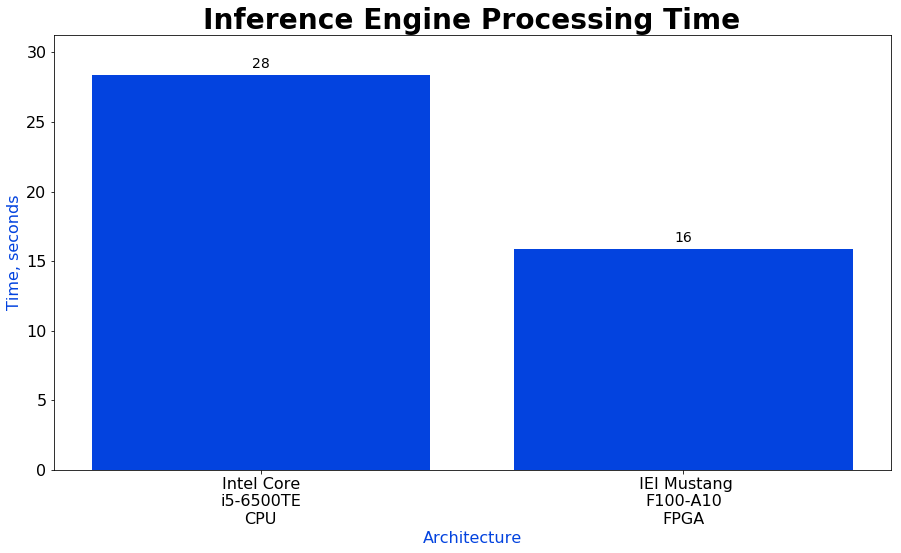

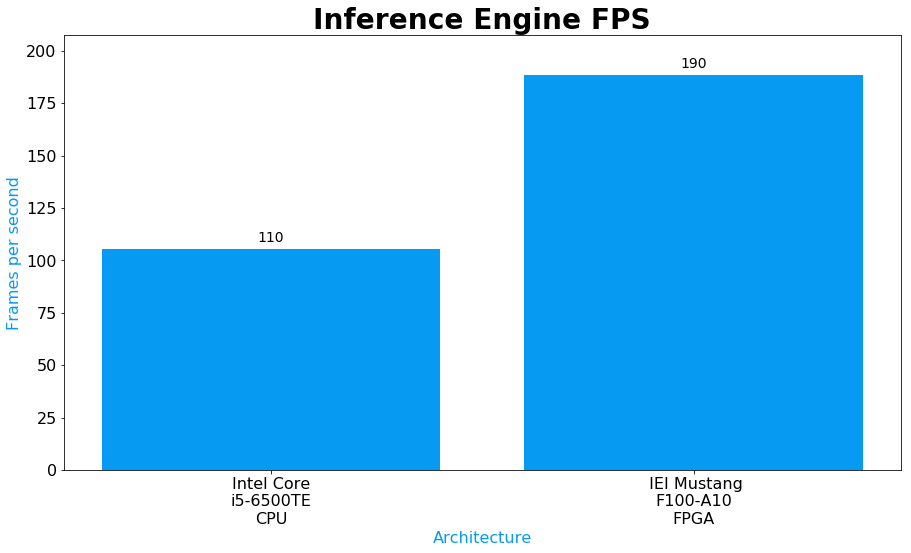

In [13]:
arch_list = [('core', 'Intel Core\ni5-6500TE\nCPU'),
             ('fpga', ' IEI Mustang\nF100-A10\nFPGA'),]

stats_list = []
for arch, a_name in arch_list:
    if 'job_id_'+arch in vars():
        stats_list.append(('results/{arch}/stats.txt'.format(arch=arch), a_name))
    else:
        stats_list.append(('placeholder'+arch, a_name))

summaryPlot(stats_list, 'Architecture', 'Time, seconds', 'Inference Engine Processing Time', 'time' )
summaryPlot(stats_list, 'Architecture', 'Frames per second', 'Inference Engine FPS', 'fps' )